In [9]:
import os
import openpyxl

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
import statsmodels.api as sm

from glob import glob
from math import ceil, floor
from pathlib import Path


from utility import mean_absolute_percentage_error, simple_regplot, plot_linear_fit, plot_best_ransac_fit, evaluation

In [21]:
text_in_title_para = {'fontfamily': 'sans-serif', 'fontsize': 12, 'fontweight': 20}
text_in_figure_para = {'fontfamily': 'sans-serif', 'fontsize': 8, 'fontweight': 20, 'horizontalalignment': 'left', 'verticalalignment': 'center'}

In [11]:
data_folder = Path(r'D:\Code\Apple_Crop_Potential_Prediction\data\row13\characterization')
exp_id =  r'hc_downsample_iter_7\s1'
data_folder = data_folder / exp_id
excel_files = str(data_folder / 'branch_trait.xlsx')
print(excel_files)

D:\Code\Apple_Crop_Potential_Prediction\data\row13\characterization\hc_downsample_iter_7\s1\branch_trait.xlsx


In [51]:
characterization_excel = openpyxl.load_workbook(str(excel_files))
sheetname = characterization_excel.sheetnames[0]
print(f'Sheet name: {sheetname}')
df = pd.read_excel(excel_files, sheet_name=sheetname)
df

Sheet name: branch_trait


,Branch ID,Filename,Vertical_Croth_Angle-Degree,Primary_Branch_Radius-mm,Manual_Vertical_Crotch_Angle-Degree,Manual_Branch_Diameter-mm,Primary_Branch_Diameter-mm,Adjusted
0,1,tree1,62.30,4.35,73.7,14,8.70,No
1,2,tree1,79.53,9.28,77.4,22,18.56,No
2,3,tree1,91.62,7.19,94.3,22,14.38,No
3,5,tree1,69.95,3.63,68.8,14,7.26,No
4,10,tree1,68.42,3.86,63.8,18,7.72,No
...,...,...,...,...,...,...,...,...
90,10,tree9,78.06,4.79,86.5,16,9.58,No
91,11,tree9,77.11,2.61,77.4,9,5.22,No
92,12,tree9,81.30,3.56,58.1,15,7.12,Yes
93,15,tree9,58.98,2.69,61.1,14,5.38,No


d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


9 Trees Recall 95/106


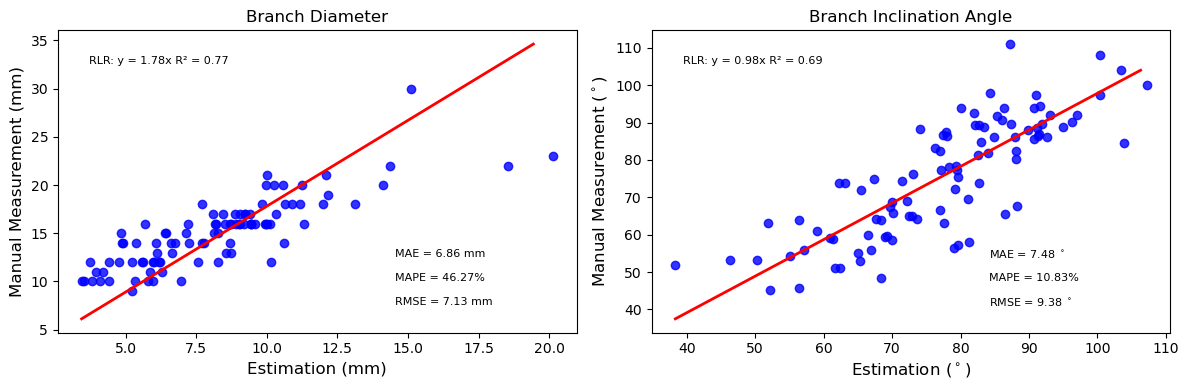

In [48]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

ci = 95
ax = axes[0]
x_axis = 'Primary_Branch_Diameter-mm' # 'Manual_Vertical_Crotch_Angle-Degree'
y_axis = 'Manual_Branch_Diameter-mm'  # 'Vertical_Croth_Angle-Degree'
metrics = evaluation(df, x=x_axis, y=y_axis, fit_intercept=False)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=df, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
# ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="Huber regressor")
ax.text(0.06, 0.9, f'RLR: y = {1.78:.2f}x R\u00b2 = {0.77:.2f}', **text_in_figure_para, transform=ax.transAxes)
# ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.26, f"MAE = {metrics['MAE']} mm", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.1, f"RMSE = {metrics['RMSE']} mm", **text_in_figure_para, transform=ax.transAxes)
ax.set_title('Branch Diameter', **text_in_title_para)
ax.set_xlabel('Estimation (mm)', **text_in_title_para)
ax.set_ylabel('Manual Measurement (mm)', **text_in_title_para)

ax = axes[1]
x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(df, x=x_axis, y=y_axis, fit_intercept=False)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=df, ci=ci, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
# ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="Huber regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0]:.2f}x R\u00b2 = {0.69:.2f}', **text_in_figure_para, transform=ax.transAxes)
# ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f} R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.26, f"MAE = {metrics['MAE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.set_title('Branch Inclination Angle', **text_in_title_para)
ax.set_xlabel('Estimation ($^\circ$)', **text_in_title_para)
ax.set_ylabel('Manual Measurement ($^\circ$)', **text_in_title_para)

fig.tight_layout()
print(f'9 Trees Recall {all_sensor_measurement}/{all_field_measurement}')
plt.savefig(str(data_folder / 'branch_trait_evaluation.png'), dpi=300)

Sheet name: Adjusted


d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


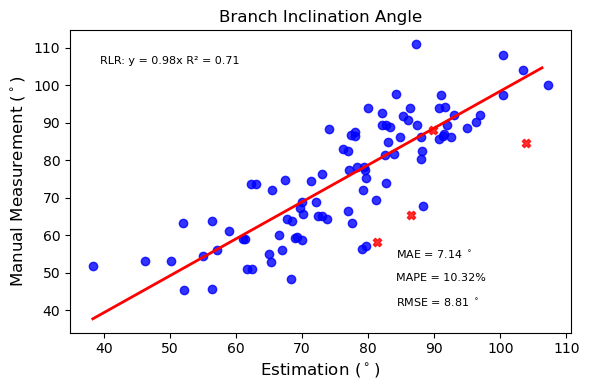

In [55]:
sheetname = characterization_excel.sheetnames[1]
print(f'Sheet name: {sheetname}')
df = pd.read_excel(excel_files, sheet_name=sheetname)

sheetname = characterization_excel.sheetnames[2]
removed_df = pd.read_excel(excel_files, sheet_name=sheetname)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(df, x=x_axis, y=y_axis, fit_intercept=False)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)
sns.regplot(x=x_axis, y=y_axis, data=removed_df, ci=None, fit_reg=False, robust=False, marker="X", scatter_kws={"color": "red"}, ax=ax)

# ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="Huber regressor")
ax.text(0.06, 0.9, f'RLR: y = {rlr_coef[0]:.2f}x R\u00b2 = {0.71:.2f}', **text_in_figure_para, transform=ax.transAxes)
# ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f} R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.26, f"MAE = {metrics['MAE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.set_title('Branch Inclination Angle', **text_in_title_para)
ax.set_xlabel('Estimation ($^\circ$)', **text_in_title_para)
ax.set_ylabel('Manual Measurement ($^\circ$)', **text_in_title_para)

fig.tight_layout()
# plt.savefig(str(data_folder / 'branch_trait_evaluation_adjusted.png'), dpi=300)

In [56]:
data_folder = Path(r'D:\Code\Apple_Crop_Potential_Prediction\data\row13\characterization')
exp_id =  r'hc_downsample_iter_7\s1'
data_folder = data_folder / exp_id
excel_files = str(data_folder / 'treeA_branch_test.xlsx')
print(excel_files)

D:\Code\Apple_Crop_Potential_Prediction\data\row13\characterization\hc_downsample_iter_7\s1\treeA_branch_test.xlsx


Sheet name: Branch_Level_Traits_1


d:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:1141: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


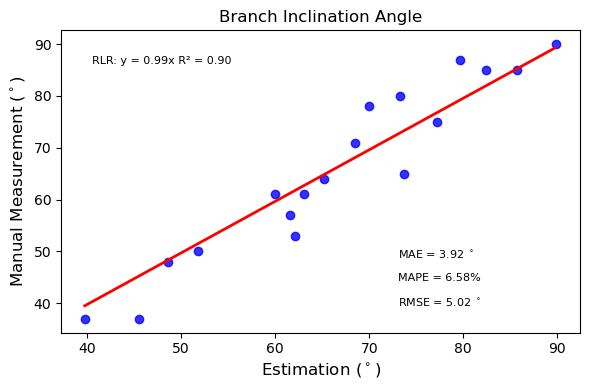

In [60]:
characterization_excel = openpyxl.load_workbook(str(excel_files))
sheetname = characterization_excel.sheetnames[0]
print(f'Sheet name: {sheetname}')

df = pd.read_excel(excel_files, sheet_name=sheetname)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,4))

x_axis = 'Vertical_Croth_Angle-Degree'
y_axis = 'Manual_Vertical_Crotch_Angle-Degree'
metrics = evaluation(df, x=x_axis, y=y_axis, fit_intercept=False)
lr_x, lr_y, lr_coef, lr_intercept, lr_score = metrics['LR']
ransac_lr_x, ransac_lr_y, rlr_coef, rlr_intercept, rlr_score = metrics['RLR']
sns.regplot(x=x_axis, y=y_axis, data=df, ci=None, fit_reg=False, robust=False, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, ax=ax)

# ax.plot(lr_x, lr_y, color="green", linewidth=2, label="Linear regressor")
ax.plot(ransac_lr_x, ransac_lr_y, color="red", linewidth=2, label="Huber regressor")
ax.text(0.06, 0.9, f'y = {rlr_coef[0]:.2f}x R\u00b2 = {rlr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
# ax.text(0.06, 0.82, f'LR:   y = {lr_coef[0][0]:.2f}x+{lr_intercept[0]:.2f} R\u00b2 = {lr_score:.2f}', **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.26, f"MAE = {metrics['MAE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.18, f"MAPE = {metrics['MAPE']}%", **text_in_figure_para, transform=ax.transAxes)
ax.text(0.65, 0.1, f"RMSE = {metrics['RMSE']} $^\circ$", **text_in_figure_para, transform=ax.transAxes)
ax.set_title('Branch Inclination Angle', **text_in_title_para)
ax.set_xlabel('Estimation ($^\circ$)', **text_in_title_para)
ax.set_ylabel('Manual Measurement ($^\circ$)', **text_in_title_para)

fig.tight_layout()
plt.savefig(str(data_folder / 'simulation_branch_evaluation_adjusted.png'), dpi=300)